# Download and plot liquid freshwater discharge

"Freshwater  discharge  from  Greenland  primarily  takes three  forms: <br>
1) solid  ice  from  calving  at  marine-terminating glaciers <br>
2) submarine  meltwater  from  ice–ocean  boundary melting  at  marine-terminating  glaciers <br>
3) liquid  runoff from melted inland surface ice, rain, and condensation." <br>

1 and 2 are included in the solid ice discharge dataset and 3 is covered in the liquid discharge dataset plotted here

Runoff, R, is defined by: <br>
R = ME + RA − RT − RF. (1) <br>
In Eq. (1), ME is melt, RA is rainfall, RT is retention, and RF is refreezing.
Runoff
is assigned an uncertainty of ± 15 % (Sect. 4.3.3).

– **Runoff** refers to the unmodified RCM data products – melted ice, rain, condensation, and evaporation – that comprise the RCM runoff output variable.<br>
– **Discharge** refers to the runoff after it has been processed by this work – routed to and aggregated at the outlets. Depending on context, discharge may also refer to the observed stream discharge (Table 1).

"Both this product and Mankoff et al. (2020) provide liquid or solid freshwater volume flow rates at outlets (this product) or grounding lines (Mankoff et al., 2020), but actual fresh- water  discharge  into  a  fjord  occurs  at  a  more  complicated range of locations. Solid ice melts throughout the fjord and beyond (e.g., Enderlin et al., 2016; Moon et al., 2017), and the freshwater discharge presented here may enter at the re- ported depth (Sect. 4.3.6) but rapidly rises up the ice front and  eventually  flows  into  the  fjord  at  some  isopycnal  (see Mankoff et al., 2016). The eventual downstream location of the fresh water is not addressed in this work."

**there are temporal errors associated with this product**: <br>
"From this, the product is more appropriately used to estimate the magnitude of the discharge from any individ- ual basin, and perhaps provide some idea of the statisti- cal variability, but not necessarily the precise amount of discharge for any specific day, because routing delays are neglected."

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
from matplotlib import cm
from pyproj import Proj, transform, Transformer, CRS
from matplotlib.colors import ListedColormap

# for progress bar
from tqdm.notebook import tqdm_notebook

Code and README: https://github.com/GEUS-Glaciology-and-Climate/freshwater <br>
Data: https://doi.org/10.22008/promice/freshwater

https://dataverse.geus.dk/dataset.xhtml?persistentId=doi:10.22008/FK2/AA6MTB

run these lines of code in GitBash (cat is a UNIX command, not available on Windows but will work using GitBash on a windows machine)
>wget https://dataverse.geus.dk/api/datasets/:persistentId?persistentId=doi:10.22008/FK2/AA6MTB -O tmp.json

>cat tmp.json | tr ',' '\n' | grep -E '"persistentId"|"directoryLabel"|"filename"' | cut -d'"' -f4 > urls.txt

Run this loop to download each file using the filenames in the urls.txt file

In [ ]:
# identify directory for where to save files
# download_root_dir = '../../../data/Mankoff_discharge/liquid_discharge/freshwater/'
download_root_dir = 'D:/Mankoff_discharge_data/liquid_discharge/freshwater/' # external harddrive with 'OMG_Narwhals' sticker

# open .txt file that was created using Ken's bash parsing code (above)
f = open('C:/Users/marie/urls.txt').read().split()

# loop to open urls.txt file and iterate through dir, doi, filename using wget to download the file
for i in np.arange(0,len(f),3): # go through every 3 lines
    file_info = f[i:i+3]
    print(file_info)
    # isolate each
    file_dir = file_info[0] + '/'
    doi = file_info[1]
    filename = file_info[2]
    # download file using wget command
    !wget https://dataverse.geus.dk/api/access/datafile/:persistentId?persistentId={doi} -O {download_root_dir + file_dir + filename}

## Define functions to query NetCDF files

Each basin (land or ice) supplies freshwater to the determined outlet locations (1 for each basin). Outlets that cover the main upstream drainage basin associated with a particular fjord are summed and plotted.

**Mouginot (2019) and Bjørk (2015) names:** <br>
KONG_OSCAR_GLETSCHER (Nuussuup Sermia) <br>
RINK_GLETSCHER (Rink Gletsjer) <br>
SVERDRUP_GLETSCHER (Sverdrup Gletsjer) 

In [70]:
def get_freshwater_discharge_data(data_dir, output_dir, get_years=['2019'], station_name='Rink Gletsjer', range_filter='TRUE', range_meters=8000):
    """
    Function that opens and combines multiple years of RACMO and MAR freshwater discharge data (land and ice) for a specific
    glacier basin ('station_name'), using Bjørk (2015) official names. 
    
    If range_filter='TRUE', discharge data will be filtered for outlets within the specified range ('range_meters') from the glacier basin.
    
    Returns two datasets, 'racmo_discharge_ds' and 'mar_discharge_ds,' which include land and ice freshwater discharge estimates from RACMO and MAR 
    regional climate models, respectively.
    
    saves netcdfs of these two datasets in 'output_dir'
    """
    for i in tqdm_notebook(range(len(get_years)), desc='query netcdfs'):     
        # open datasets
        racmo_ice_ds = xr.open_dataset(discharge_data_dir + '/ice/discharge/RACMO_' + get_years[i] +  '.nc')
        mar_ice_ds   = xr.open_dataset(discharge_data_dir + '/ice/discharge/MAR_' + get_years[i] +  '.nc')
        racmo_land_ds = xr.open_dataset(discharge_data_dir + '/land/discharge/RACMO_' + get_years[i] +  '.nc')
        mar_land_ds   = xr.open_dataset(discharge_data_dir + '/land/discharge/MAR_' + get_years[i] +  '.nc')
        
        # query datasets for station (glacier) and distance of outlets from glacier basin
        tmp_racmo_ice  = racmo_ice_ds.where(racmo_ice_ds.B2015_name==station_name, drop=True)
        tmp_mar_ice    = mar_ice_ds.where(mar_ice_ds.B2015_name==station_name, drop=True)
        tmp_racmo_land = racmo_land_ds.where(racmo_land_ds.B2015_name==station_name, drop=True)
        tmp_mar_land   = mar_land_ds.where(mar_land_ds.B2015_name==station_name, drop=True)
        
        if range_filter=='TRUE':
            tmp_racmo_ice  = tmp_racmo_ice.where(tmp_racmo_ice.B2015_dist<range_meters, drop=True)
            tmp_mar_ice    = tmp_mar_ice.where(tmp_mar_ice.B2015_dist<range_meters, drop=True) 
            tmp_racmo_land = tmp_racmo_land.where(tmp_racmo_land.B2015_dist<range_meters, drop=True)
            tmp_mar_land   = tmp_mar_land.where(tmp_mar_land.B2015_dist<range_meters, drop=True)
        
        # reassign B2015_dist as a coordinate for option to index by this later
        racmo_ice_all  = tmp_racmo_ice.discharge.assign_coords(B2015_dist=('station', tmp_racmo_ice.B2015_dist.values))
        mar_ice_all    = tmp_mar_ice.discharge.assign_coords(B2015_dist=('station', tmp_mar_ice.B2015_dist.values))
        racmo_land_all = tmp_racmo_land.discharge.assign_coords(B2015_dist=('station', tmp_racmo_land.B2015_dist.values))
        mar_land_all   = tmp_mar_land.discharge.assign_coords(B2015_dist=('station', tmp_mar_land.B2015_dist.values))
        
        if i==0:
            racmo_ice_tmp  = racmo_ice_all.copy(deep=True)
            mar_ice_tmp    = mar_ice_all.copy(deep=True) 
            racmo_land_tmp = racmo_land_all.copy(deep=True)
            mar_land_tmp   = mar_land_all.copy(deep=True)
        else:
            racmo_ice_tmp  =  xr.concat([racmo_ice_tmp, racmo_ice_all], dim='time')
            mar_ice_tmp    =  xr.concat([mar_ice_tmp, mar_ice_all], dim='time')
            racmo_land_tmp =  xr.concat([racmo_land_tmp, racmo_land_all], dim='time')
            mar_land_tmp   =  xr.concat([mar_land_tmp, mar_land_all], dim='time')
        
        # combine land and ice datasets with new dimension and coordinates
        racmo_discharge_ds = xr.concat([racmo_ice_tmp, racmo_land_tmp], 'basin_type').assign_coords(basin_type=['ice', 'land'])
        mar_discharge_ds = xr.concat([mar_ice_tmp, mar_land_tmp], 'basin_type').assign_coords(basin_type=['ice', 'land'])
    
    filename = station_name.split()[0] + '_' + station_name.split()[1] +'.nc'
    racmo_discharge_ds.to_netcdf(output_dir + '/racmo_freshwater_discharge_' + filename)
    mar_discharge_ds.to_netcdf(output_dir + '/mar_freshwater_discharge_' + filename)
    
    return racmo_discharge_ds, mar_discharge_ds

In [71]:
# function that reprojects lat/lon coordinates to polar stereographic
# lat/lon coordinates are needed in the functions below
def transform_projection_to_Npolar(line_da):
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413', always_xy=True)
    xx, yy = transformer.transform(line_da.lon.values, line_da.lat.values)
    return xx,yy

### Import bathymetry data

In [46]:
# import bathymetry data
bedmachine_ds = xr.open_dataset('../../../data/bathymetry/BedMachine_v5_regions/bedmachineV5_moorings_region.nc')

In [47]:
# create mask for only bathymetry values less than zero (below surface) - set values > 0 to zero.
bed_masked_ds = bedmachine_ds.bed.where(bedmachine_ds.bed<0, 0)

### Define directories

discharge_data_dir = 'D:/Mankoff_discharge_data/liquid_discharge/freshwater'

In [3]:
output_dir = 'netcdfs'

## Run functions

### Rink glacier

In [151]:
racmo_discharge_ds, mar_discharge_ds = get_freshwater_discharge_data(discharge_data_dir, output_dir, get_years=['2018','2019','2020'],\
                                                                     station_name='Rink Gletsjer', range_filter='FALSE', range_meters=8000)

query netcdfs:   0%|          | 0/3 [00:00<?, ?it/s]

In [79]:
tmp = racmo_discharge_ds.where(racmo_discharge_ds.B2015_dist<8000, drop=True)

In [152]:
# reproject lat/lon coords to Polar to plot with BedMachine
x_racmo, y_racmo = transform_projection_to_Npolar(racmo_discharge_ds)
x_mar, y_mar     = transform_projection_to_Npolar(mar_discharge_ds)

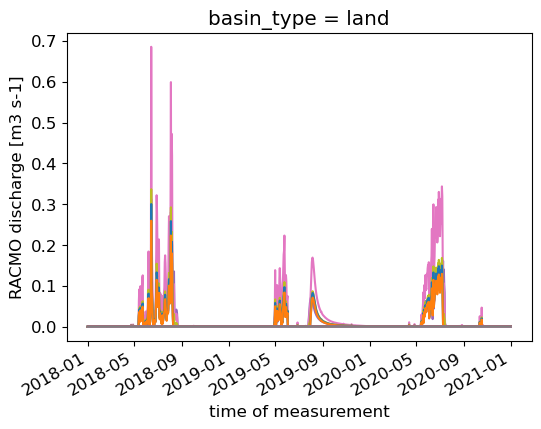

In [153]:
racmo_discharge_ds.sel(basin_type='land').plot.line(hue='station', add_legend=None, figsize=[6,4]);

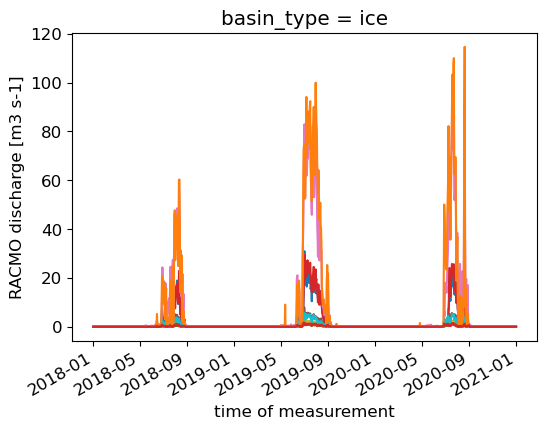

In [154]:
racmo_discharge_ds.sel(basin_type='ice').plot.line(hue='station', add_legend=None, figsize=[6,4]);

In [161]:
x_racmo

array([[-423250.06459444, -421950.02727258, -424850.11019571,
        -419750.02452882, -425649.92710742, -418149.93920801,
        -414149.91284117, -427749.97252737, -427149.98171117,
        -426850.0574379 , -425750.11842815, -412650.13382752,
        -413250.03868274, -411149.95427663, -419550.06719076,
        -415450.03057126, -414149.93510658, -416050.00976928,
        -410250.01460876, -407550.06830351, -417549.93826953,
        -406949.98001229, -406950.09327163, -407449.98491195,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan],
       

In [162]:
colors

<xarray.DataArray 'discharge' (basin_type: 2, station: 48)>
array([[3.09517597e+01, 2.77908446e+00,            nan, 2.94127203e+01,
                   nan, 8.03489874e+00, 9.25100665e+01,            nan,
                   nan,            nan,            nan, 2.56186412e+00,
                   nan, 1.12460965e+00,            nan,            nan,
                   nan,            nan, 2.75294942e+00, 5.62865895e+00,
                   nan, 1.14629912e+02, 1.34526058e+00, 1.82731687e+00,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
        3.12709196e-01, 0.00000000e+00, 6.85517636e-01, 0.00000000e+00,
        3.36733310e-01, 1.98896023e-03, 3.00504296e-01, 2.59640935e-01,
        1.56905200e-04, 5.58590836e-04, 2.12643772e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * station     (station) uint64 30413 30434 30467 30479 ... 45012 45013 45570
    lat         (basin_type, station) float32 76.24 76.23 76.22 ... 76.17 76.03
    lon         (basin_type, station) float32 -61.41 -61.36 ... -60.71 -61.69
    alt         (basin_type, station) float32 -176.0 -115.0 16.0 ... -80.0 15.0
    B2015_dist  (basin_type, station) float64 1.103e+04 9.601e+03 ... 2.786e+04
  * basin_type  (basin_type) <U4 'ice' 'land'

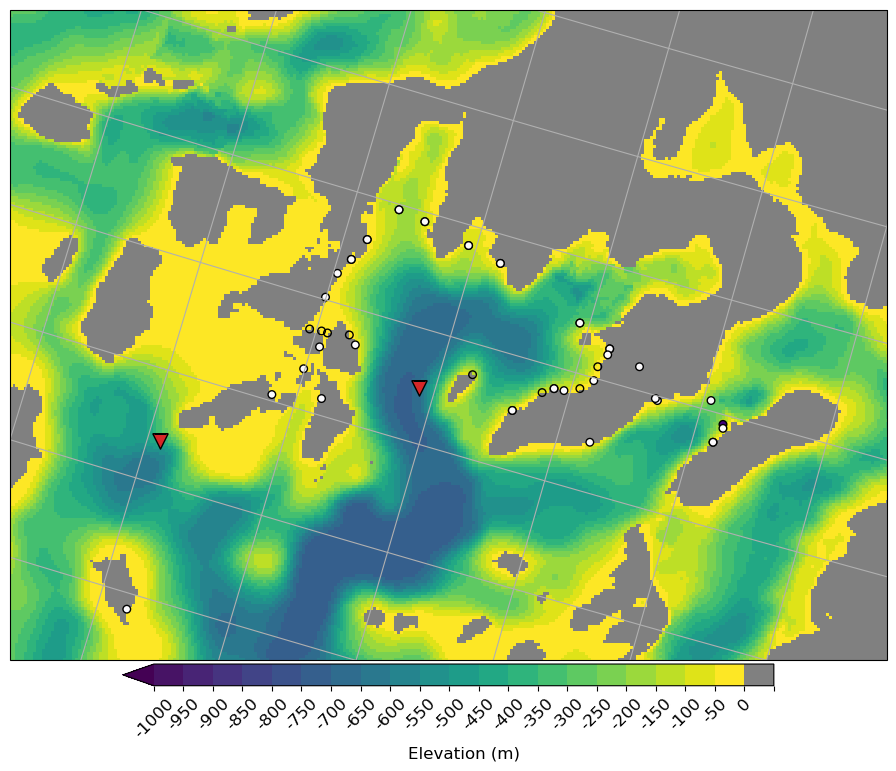

In [157]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = '12'
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-62, -60.5, 76.5, 76.7], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap('viridis', 21)
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0, 1, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]
ticks = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]

pc = bed_masked_ds.plot.pcolormesh('x','y',ax=ax,transform=ccrs.NorthPolarStereo(central_longitude = -45),\
                                   shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',\
                    shrink=0.7,spacing='uniform',pad=0.005,aspect=30)
cbar.ax.set_xticklabels(np.append(ticks[:-1], ''),rotation=45)

# ax.coastlines(linewidths=0.7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

# plot outlet locations
colors = racmo_discharge_ds.max(['time'])
plt.scatter(x_racmo, y_racmo,c=colors, cmap='Purples',marker='o',edgecolors='k',s=30,transform=ccrs.NorthPolarStereo(central_longitude = -45));
# plt.scatter(x_mar, y_mar,color='tab:red',marker='+',s=8,transform=ccrs.NorthPolarStereo(central_longitude = -45));

# add mooring locations
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413', always_xy=True)
x_rink, y_rink = transformer.transform(-61.279117, 76.160533)
x_fisher, y_fisher = transformer.transform(-61.726983, 76.103817)

ax.scatter(x_rink, y_rink, s=120, c='tab:red',edgecolor='black',marker="v",transform=ccrs.NorthPolarStereo(central_longitude = -45))
ax.scatter(x_fisher, y_fisher, s=120, c='tab:red',edgecolor='black',marker="v",transform=ccrs.NorthPolarStereo(central_longitude = -45));

# plt.savefig("Figures/sverdrup_ridgelines.png", bbox_inches='tight', dpi=300, facecolor='white')

### Kong Oscar glacier

In [163]:
racmo_discharge_ds, mar_discharge_ds = get_freshwater_discharge_data(discharge_data_dir, output_dir, get_years=['2018','2019','2020'],\
                                                                     station_name='Nuussuup Sermia', range_filter='FALSE', range_meters=8000)

query netcdfs:   0%|          | 0/3 [00:00<?, ?it/s]

In [79]:
tmp = racmo_discharge_ds.where(racmo_discharge_ds.B2015_dist<8000, drop=True)

In [164]:
# reproject lat/lon coords to Polar to plot with BedMachine
x_racmo, y_racmo = transform_projection_to_Npolar(racmo_discharge_ds)
x_mar, y_mar     = transform_projection_to_Npolar(mar_discharge_ds)

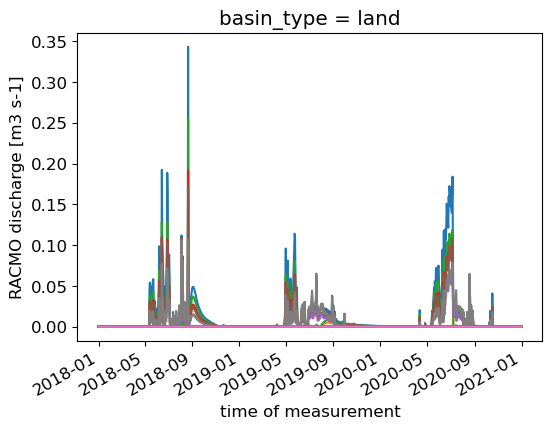

In [165]:
racmo_discharge_ds.sel(basin_type='land').plot.line(hue='station', add_legend=None, figsize=[6,4]);

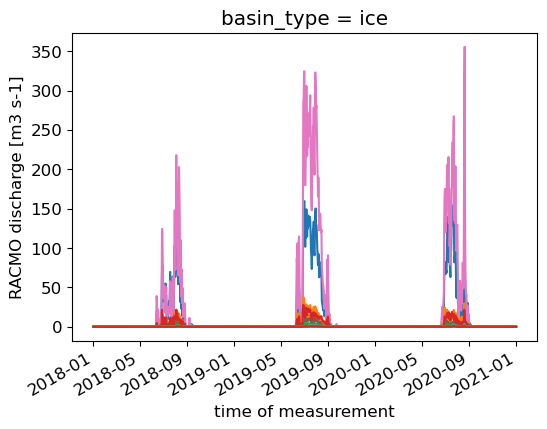

In [166]:
racmo_discharge_ds.sel(basin_type='ice').plot.line(hue='station', add_legend=None, figsize=[6,4]);

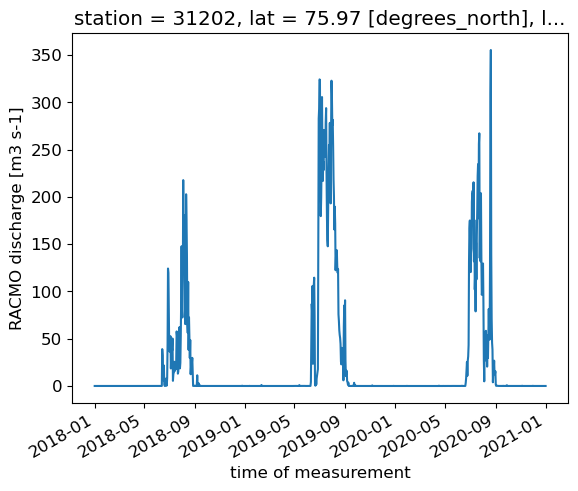

In [174]:
racmo_discharge_ds.sel(station=31202).sel(basin_type='ice').plot();

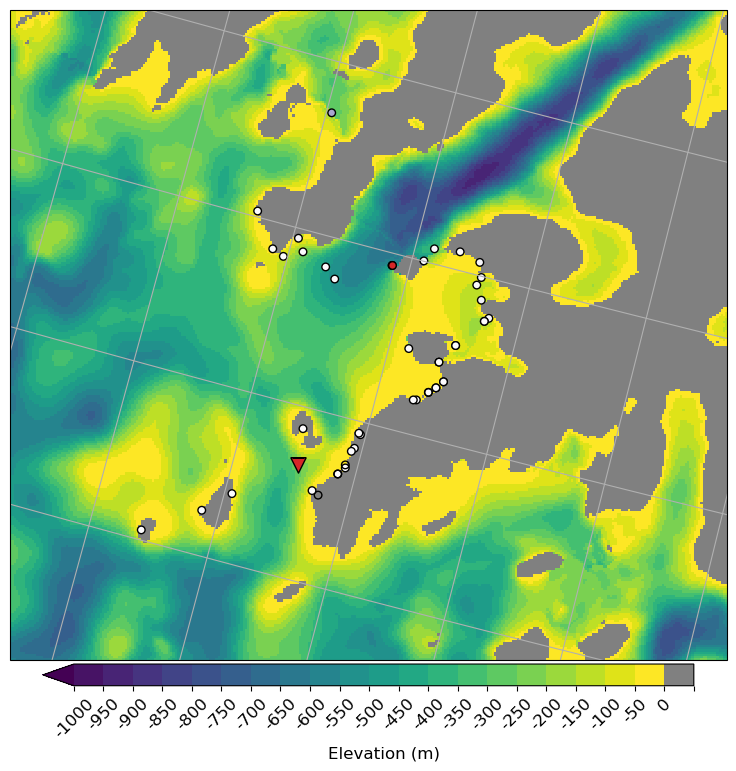

In [183]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = '12'
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
# ax.set_extent([-60.5, -59, 76, 76.6], ccrs.PlateCarree())
ax.set_extent([-60.5, -59, 76.2, 76.5], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap('viridis', 21)
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0, 1, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]
ticks = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]

pc = bed_masked_ds.plot.pcolormesh('x','y',ax=ax,transform=ccrs.NorthPolarStereo(central_longitude = -45),\
                                   shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',\
                    shrink=0.7,spacing='uniform',pad=0.005,aspect=30)
cbar.ax.set_xticklabels(np.append(ticks[:-1], ''),rotation=45)

# ax.coastlines(linewidths=0.7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

# plot outlet locations
colors = racmo_discharge_ds.max(['time'])
plt.scatter(x_racmo, y_racmo,c=colors, cmap='Purples',vmax = 350,marker='o',edgecolors='k',s=30,transform=ccrs.NorthPolarStereo(central_longitude = -45));
# plt.scatter(x_mar, y_mar,color='tab:red',marker='o',s=10,transform=ccrs.NorthPolarStereo(central_longitude = -45))

# plot mooring location
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413', always_xy=True)
x_KO, y_KO = transformer.transform(-59.8429, 75.843683)
ax.scatter(x_KO, y_KO, s=120, c='tab:red', edgecolor='black',marker="v",transform=ccrs.NorthPolarStereo(central_longitude = -45));

# station=31202
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413', always_xy=True)
xx, yy = transformer.transform(-59.743946, 75.974045)
plt.scatter(xx,yy, s=30, c='tab:red', edgecolor='black',marker="o",transform=ccrs.NorthPolarStereo(central_longitude = -45));

# plt.savefig("Figures/sverdrup_ridgelines.png", bbox_inches='tight', dpi=300, facecolor='white')

### Sverdrup glacier

In [97]:
racmo_discharge_ds, mar_discharge_ds = get_freshwater_discharge_data(discharge_data_dir, output_dir, get_years=['2018','2019','2020'],\
                                                                     station_name='Sverdrup Gletsjer', range_filter='FALSE', range_meters=8000)

query netcdfs:   0%|          | 0/3 [00:00<?, ?it/s]

In [79]:
tmp = racmo_discharge_ds.where(racmo_discharge_ds.B2015_dist<8000, drop=True)

In [98]:
# reproject lat/lon coords to Polar to plot with BedMachine
x_racmo, y_racmo = transform_projection_to_Npolar(racmo_discharge_ds)
x_mar, y_mar     = transform_projection_to_Npolar(mar_discharge_ds)

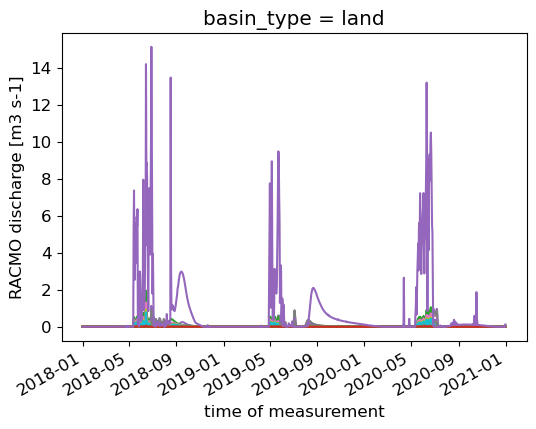

In [139]:
racmo_discharge_ds.sel(basin_type='land').plot.line(hue='station', add_legend=None, figsize=[6,4]);

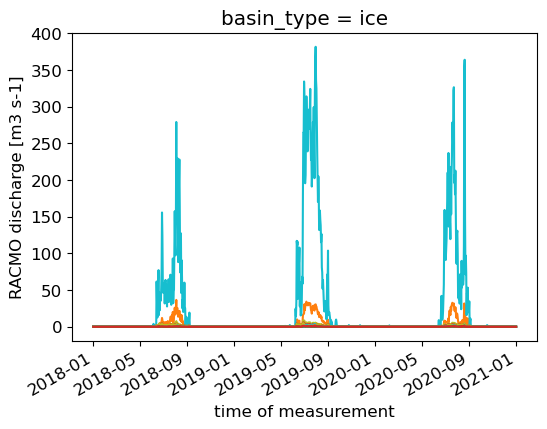

In [140]:
racmo_discharge_ds.sel(basin_type='ice').plot.line(hue='station', add_legend=None, figsize=[6,4]);

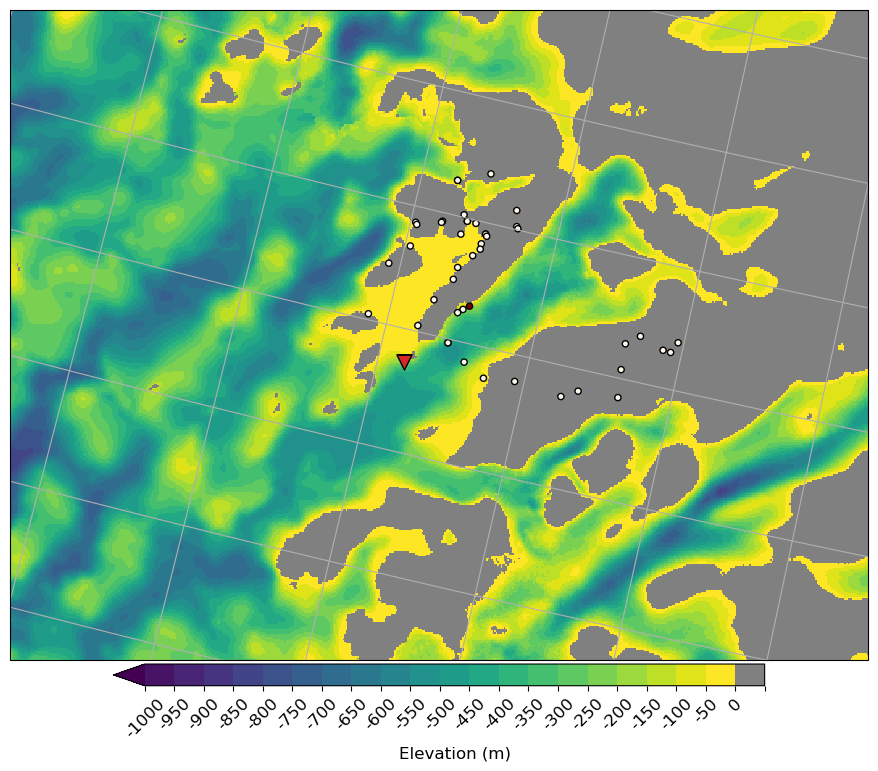

In [150]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = '12'
ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -45))
ax.set_extent([-59.6, -57, 75.8, 76.2], ccrs.PlateCarree())

# define top and bottom colormaps 
bathy = cm.get_cmap('viridis', 21)
surface = (.5, .5, .5, 1.0)
newcolors = np.vstack((bathy(np.linspace(0, 1, 21)),
                       surface)) # create a new colormaps
ocean_land = ListedColormap(newcolors, name='ocean_land')
bounds = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]
ticks = [-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,0,0.1]

pc = bed_masked_ds.plot.pcolormesh('x','y',ax=ax,transform=ccrs.NorthPolarStereo(central_longitude = -45),\
                                   shading='auto',rasterized=True,cmap=ocean_land,levels=bounds,add_colorbar=False)
cbar = plt.colorbar(pc, label='Elevation (m)',ticks=ticks,boundaries=bounds,orientation='horizontal',\
                    shrink=0.7,spacing='uniform',pad=0.005,aspect=30)
cbar.ax.set_xticklabels(np.append(ticks[:-1], ''),rotation=45)

# ax.coastlines(linewidths=0.7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

# plot outlet locations
colors = racmo_discharge_ds.max(['time'])
plt.scatter(x_racmo, y_racmo,c=colors, cmap='OrRd',marker='o',edgecolors='k',s=20,transform=ccrs.NorthPolarStereo(central_longitude = -45));
# plt.scatter(x_mar, y_mar,color='tab:red',marker='o',s=10,transform=ccrs.NorthPolarStereo(central_longitude = -45))

# plot mooring location
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3413', always_xy=True)
x_sver, y_sver = transformer.transform(-58.410533, 75.5413)

ax.scatter(x_sver, y_sver, s=120, c='tab:red', edgecolor='black',marker="v",transform=ccrs.NorthPolarStereo(central_longitude = -45));

# plt.savefig("Figures/sverdrup_ridgelines.png", bbox_inches='tight', dpi=300, facecolor='white')

***

In [7]:
# sverdrup
ds_sverdrup_racmo = ds_racmo_index.sel(station='Sverdrup Gletsjer').sum(dim='station')
ds_sverdrup_mar = ds_mar_index.sel(station='Sverdrup Gletsjer').sum(dim='station')

# kong oscar
ds_KO_racmo = ds_racmo_index.sel(station='Nuussuup Sermia').sum(dim='station')
ds_KO_mar = ds_mar_index.sel(station='Nuussuup Sermia').sum(dim='station')

# Rink
ds_rink_racmo = ds_racmo_index.sel(station='Rink Gletsjer').sum(dim='station')
ds_rink_mar = ds_mar_index.sel(station='Rink Gletsjer').sum(dim='station')

In [8]:
ds_KO_racmo

<xarray.Dataset>
Dimensions:            (time: 366)
Coordinates:
  * time               (time) datetime64[ns] 2020-01-01 ... 2020-12-31
Data variables:
    discharge          (time) float64 0.07731 0.07915 0.07819 ... 0.1187 0.1003
    Z2012_sector       uint32 2025
    Z2012_sector_dist  uint32 49739
    M2019_ID           uint32 3311
    M2019_ID_dist      uint32 2214
    M2020_gate         uint32 1900
    M2020_gate_dist    uint32 250216
    B2015_dist         int64 240753
    coast_id           uint32 1158004
    coast_lat          float32 1.898e+03
    coast_lon          float32 -1.492e+03
    coast_alt          float32 -2.32e+03

In [69]:
ds_racmo_index19 = ds_racmo19.set_index(station=("B2015_name"))
ds_mar_index19 = ds_mar19.set_index(station=("B2015_name"))

In [70]:
# sverdrup
ds_sverdrup_racmo19 = ds_racmo_index19.sel(station='Sverdrup Gletsjer').sum(dim='station')
ds_sverdrup_mar19 = ds_mar_index19.sel(station='Sverdrup Gletsjer').sum(dim='station')

# kong oscar
ds_KO_racmo19 = ds_racmo_index19.sel(station='Nuussuup Sermia').sum(dim='station')
ds_KO_mar19 = ds_mar_index19.sel(station='Nuussuup Sermia').sum(dim='station')

# Rink
ds_rink_racmo19 = ds_racmo_index19.sel(station='Rink Gletsjer').sum(dim='station')
ds_rink_mar19 = ds_mar_index19.sel(station='Rink Gletsjer').sum(dim='station')

In [1]:
ds_KO_mar19

NameError: name 'ds_KO_mar19' is not defined

Include a 7-day running mean based on:<br>
"RCM runoff is summed over each basin for each day of RCM data and assigned to each outlet for that day. This assumes routing between the runoff and the outlet is instantaneous, so  all  analyses  done  here  include  a  7 d  smooth  applied  to the  RCM  discharge  product  (cf.  van  As  et  al.,  2017).  The released data do not include any smoothing." from paper

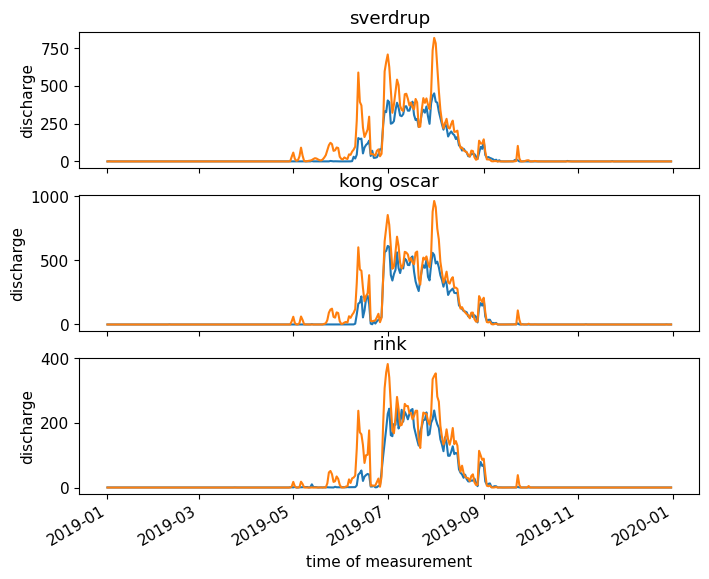

In [71]:
fig, axs = plt.subplots(3)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] = 11

ds_sverdrup_racmo19.discharge.plot(ax=axs[0])
ds_sverdrup_mar19.discharge.plot(ax=axs[0])
axs[0].set_title("sverdrup")
axs[0].xaxis.set_ticklabels([])
axs[0].set_xlabel("")

ds_KO_racmo19.discharge.plot(ax=axs[1])
ds_KO_mar19.discharge.plot(ax=axs[1])
axs[1].set_title("kong oscar")
axs[1].xaxis.set_ticklabels([])
axs[1].set_xlabel("")

ds_rink_racmo19.discharge.plot(ax=axs[2])
ds_rink_mar19.discharge.plot(ax=axs[2])
axs[2].set_title("rink");

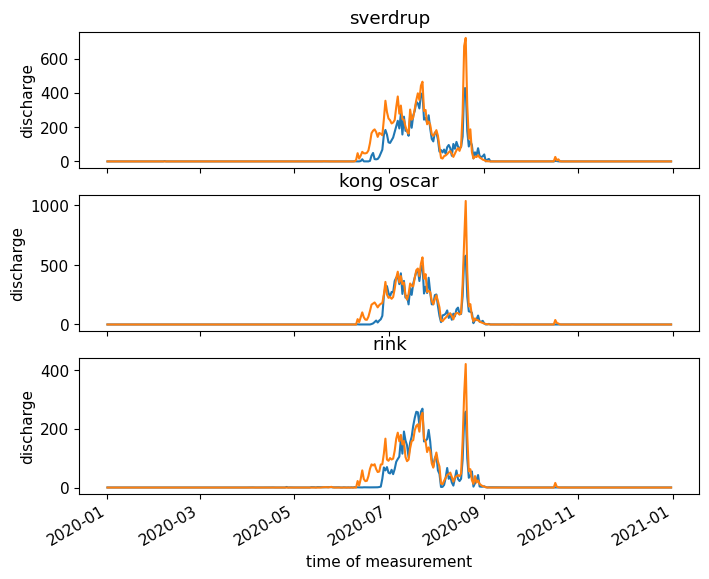

In [67]:
fig, axs = plt.subplots(3)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] = 11

ds_sverdrup_racmo.discharge.plot(ax=axs[0])
ds_sverdrup_mar.discharge.plot(ax=axs[0])
axs[0].set_title("sverdrup")
axs[0].xaxis.set_ticklabels([])
axs[0].set_xlabel("")

ds_KO_racmo.discharge.plot(ax=axs[1])
ds_KO_mar.discharge.plot(ax=axs[1])
axs[1].set_title("kong oscar")
axs[1].xaxis.set_ticklabels([])
axs[1].set_xlabel("")

ds_rink_racmo.discharge.plot(ax=axs[2])
ds_rink_mar.discharge.plot(ax=axs[2])
axs[2].set_title("rink");

Index using Ken's py script and input ROI

In [ ]:
from discharge import discharge 
df = discharge(base=discharge_data_dir, roi="-50.5,67.2", quiet=True).outlets()